In [62]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

import yfinance as yf
from typing import List
from pandas_datareader import data as pdr

from matplotlib import pyplot as plt

pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15, 10]


# Sentiment Data Cleaning

In [3]:
file = 'basic_data/tweets_new.csv'
df = pd.read_csv(file, index_col=None, lineterminator='\n', header=0, names=['Datetime', 'Clean_Text', 'Text', 'Subjectivity', 'Polarity', 'Sentiment'], dtype='unicode')
raw_data = df[['Datetime','Subjectivity', 'Polarity', 'Sentiment']]
POLARITY, SENTIMENT = "Polarity", "Sentiment"
raw_data

,Datetime,Subjectivity,Polarity,Sentiment
0,2021-10-25 16:02:34+00:00,0.41818181818181815,0.5454545454545454,POSITIVE
1,2021-10-25 14:36:53+00:00,0.0,0.0,NEUTRAL
2,2021-10-25 13:06:23+00:00,0.0,0.0,NEUTRAL
3,2021-10-24 11:54:44+00:00,0.2772727272727273,0.06818181818181818,POSITIVE
4,2021-10-23 19:03:00+00:00,0.0,0.0,NEUTRAL
...,...,...,...,...
246381,2021-10-22 13:54:20+00:00,0.0,0.0,NEUTRAL
246382,2021-10-22 13:42:46+00:00,0.7555555555555555,0.03333333333333336,POSITIVE
246383,2021-08-23 18:53:01+00:00,0.0,0.0,NEUTRAL
246384,2018-09-06 22:12:41+00:00,0.1,0.0,NEUTRAL


In [4]:
raw_data["Datetime"] = pd.to_datetime(raw_data["Datetime"]).dt.date
raw_data[POLARITY] = raw_data[POLARITY].astype('float')

In [5]:
POSITIVE_THRESHOLD = 0.2
NEGATIVE_THRESHOLD = -POSITIVE_THRESHOLD
POSITIVE, NEUTRAL, NEGATIVE = 'Positive', 'Neutral', 'Negative'

conditions = [(raw_data[POLARITY] > POSITIVE_THRESHOLD),
              (raw_data[POLARITY] < NEGATIVE_THRESHOLD)]
raw_data[SENTIMENT] = np.select(conditions, [POSITIVE, NEGATIVE], default=NEUTRAL)

In [6]:
result =  pd.pivot_table(raw_data[["Datetime", SENTIMENT]],
                          index='Datetime', columns=SENTIMENT, aggfunc=len, fill_value=0)
normalized_result = result.div(result.sum(axis=1), axis=0)[["Positive", "Negative"]]

In [7]:
normalized_result

Sentiment,Positive,Negative
Datetime,,
2017-01-01,0.391304,0.043478
2017-01-02,0.464789,0.098592
2017-01-03,0.333333,0.027778
2017-01-04,0.247748,0.027027
2017-01-05,0.238971,0.051471
...,...,...
2021-10-21,0.278761,0.039823
2021-10-22,0.163366,0.029703
2021-10-23,0.265306,0.122449


In [8]:
start_date = normalized_result.head(1).index.values[0]
end_date = normalized_result.tail(1).index.values[0]

# Get Financial Data

In [9]:
def get_financial_time_series(symbol: str, start_date: str, end_date: str,
                              type: List[str] = ('Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume')):
    return pdr.get_data_yahoo(symbol, start=start_date, end=end_date)[type]


def get_returns_time_series(symbol: str, start_date: str, end_date: str):
    close_price = get_financial_time_series(symbol, start_date, end_date, ["Close"])
    return np.log1p(close_price["Close"].pct_change()).dropna()

In [10]:
financial_data = get_returns_time_series("^GSPC", start_date, end_date)
full_data = normalized_result.join(financial_data)[["Close", POSITIVE, NEGATIVE]].dropna()
full_data

,Close,Positive,Negative
Datetime,,,
2017-01-04,0.005706,0.247748,0.027027
2017-01-05,-0.000771,0.238971,0.051471
2017-01-06,0.003511,0.283105,0.041096
2017-01-09,-0.003555,0.225131,0.052356
2017-01-10,0.000000,0.267442,0.034884
...,...,...,...
2021-10-19,0.007366,0.283422,0.053476
2021-10-20,0.003657,0.265560,0.020747
2021-10-21,0.002991,0.278761,0.039823


In [30]:
training_size = 100
prices = get_financial_time_series("^GSPC", start_date, end_date, ["Close"]) 
training_sentiment = full_data[["Positive", "Negative"]].iloc[:-training_size]
training_return, training_negative = full_data["Close"].iloc[:-training_size], full_data["Negative"].iloc[:-training_size]

# Selecting ARIMAX Model
From the code below, seems that only negative sentiments are statistically significant enough for consideration as an external regressor, hence we remove positive sentiments from the model.

In [57]:
def get_best_model(returns, external=None):
    """
    Uses the Akaike Information Criteria (AIC) to select best order of ARMA model
    :param training_data: Training data
    :return: Params for the order
    """
    best_aic = np.inf
    best_order = None
    best_mdl = None

    pq_rng = range(5)
    for i in pq_rng:
        for j in pq_rng:
            if external is None:
                tmp_mdl = smt.ARIMA(endog=returns, order=(i, 0, j)).fit()
            else:
                tmp_mdl = smt.ARIMA(endog=returns, exog=external, order=(i, 0, j)).fit()
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic, best_order = tmp_aic, (i, 0, j)
                best_mdl = tmp_mdl
    return best_order, best_mdl

In [58]:
best_order, best_mdl = get_best_model(training_return.values)

KeyboardInterrupt: 

In [ ]:
best_order_sentiment, best_mdl_sentiment = get_best_model(training_return.values,training_sentiment.values)

In [52]:
best_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1111
Model:                 ARIMA(4, 0, 0)   Log Likelihood                3329.271
Date:                Fri, 05 Nov 2021   AIC                          -6646.543
Time:                        20:59:11   BIC                          -6616.465
Sample:                             0   HQIC                         -6635.169
                               - 1111                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          8.898e-07   5.28e-07      1.686      0.092   -1.45e-07    1.92e-06
ar.L1         -0.2214      0.013    -16.949      0.000      -0.247      -0.196
ar.L2          0.1469      0.012     12.077      0.000       0.123       0.171
ar.L3          0.0461      0.013      3.465      0.001       0.020       0.072
ar.L4         -0.0942      0.014     -6.886      0.000      -0.121      -0.067
sigma2         0.0001   2.34e-06     62.650      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             13566.65
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               5.64   Skew:                            -1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
best_mdl_sentiment.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1111
Model:                 ARIMA(3, 0, 2)   Log Likelihood                3345.827
Date:                Fri, 05 Nov 2021   AIC                          -6671.653
Time:                        20:59:12   BIC                          -6621.523
Sample:                             0   HQIC                         -6652.698
                               - 1111                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.002     -1.425      0.154      -0.008       0.001
x1          3.077e-07   1.66e-06      0.185      0.853   -2.95e-06    3.56e-06
x2             0.0183      0.007      2.806      0.005       0.006       0.031
x3            -0.0155      0.014     -1.141      0.254      -0.042       0.011
ar.L1         -0.9548      0.094    -10.138      0.000      -1.139      -0.770
ar.L2          0.1853      0.115      1.608      0.108      -0.041       0.411
ar.L3          0.2155      0.025      8.623      0.000       0.167       0.265
ma.L1          0.7364      0.098      7.488      0.000       0.544       0.929
ma.L2         -0.2108      0.098     -2.159      0.031      -0.402      -0.019
sigma2         0.0001    2.9e-06     50.103      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):             12011.55
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               5.80   Skew:                            -1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
best_order_neg, best_mdl_neg = get_best_model(training_return.values,training_negative.values)

C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\oh-my\anaconda3\envs\CS5344-Team11-Project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting pa

In [18]:
best_mdl_neg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1111
Model:                 ARIMA(4, 0, 0)   Log Likelihood                3330.120
Date:                Fri, 05 Nov 2021   AIC                          -6646.240
Time:                        20:37:00   BIC                          -6611.149
Sample:                             0   HQIC                         -6632.972
                               - 1111                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      2.016      0.044    4.42e-05       0.003
x1            -0.0208      0.013     -1.625      0.104      -0.046       0.004
ar.L1         -0.2197      0.013    -16.730      0.000      -0.245      -0.194
ar.L2          0.1484      0.012     12.339      0.000       0.125       0.172
ar.L3          0.0486      0.014      3.445      0.001       0.021       0.076
ar.L4         -0.0946      0.014     -6.796      0.000      -0.122      -0.067
sigma2         0.0001   2.32e-06     62.816      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             13715.78
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               5.72   Skew:                            -1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Testing Model

We look back 500 points of data to construct a temporary model to project for the next point using the external regressor.

There is a marginal increase in performance (predicting movement) when the negative sentiments are considered. Keep in mind however that we assume that we can get approximate sentiment for the same day. This is because the p-value of the regression when taking the lagged term is not low enough to reject the hypothesis that they have no relationship.

This suggests the time-sensitivity of tweets; information based on tweets does not linger for too long, suggesting that such strategies probably needs data of a much shorter investment horizon (eg: 15 minute basis instead of dailyt)

In [41]:
def evaluate_model(returns, external=None):
    best_order, _ = get_best_model(returns, external)
    prediction = []
    for index, i in enumerate(range(-training_size, 0, 1)):
        training_data = full_data.iloc[i-500:i]
        if external is None:
            training_model = smt.ARIMA(endog=training_data["Close"], order=best_order, trend='ct').fit()
            prediction += [training_model.forecast().values[0]]
        else: 
            training_model = smt.ARIMA(endog=training_data["Close"], exog=training_data["Negative"].values, order=best_order, trend='ct').fit()
            prediction += [training_model.forecast(exog=full_data["Negative"].iloc[index]).values[0]]
    return prediction

In [59]:
prediction_list = evaluate_model(training_return)

KeyboardInterrupt: 

In [ ]:
prediction_list_negative = evaluate_model(training_return, training_negative)

In [22]:
actual = full_data["Close"].tail(training_size).values

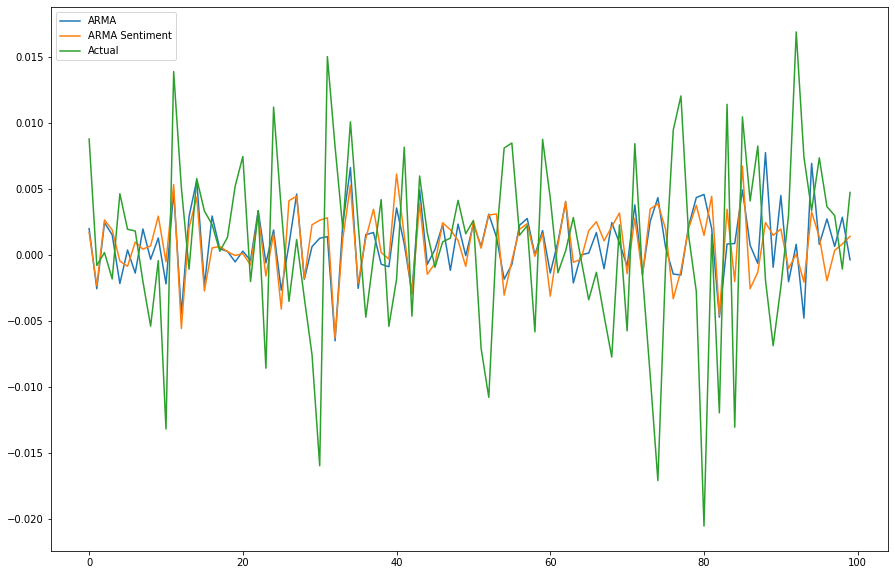

In [64]:
plt.plot(prediction_list, label='ARMA')
plt.plot(prediction_list_negative, label='ARMA Sentiment')
plt.plot(actual, label='Actual')
plt.legend()
plt.show()

In [24]:
arma_positive = np.array(prediction_list) > 0
arma_sentiment_positive = np.array(prediction_list_negative) > 0
actual_positive = np.array(actual) > 0

In [25]:
sum(arma_positive == actual_positive)/100

0.5

In [26]:
sum(arma_sentiment_positive == actual_positive)/100

0.52

In [83]:
current_price = prices.iloc[-training_size][0]
arma_price = current_price * np.exp(np.cumsum(prediction_list))
sentiment_price = current_price * np.exp(np.cumsum(prediction_list_negative))
actual_price = current_price*np.exp(np.cumsum(actual))

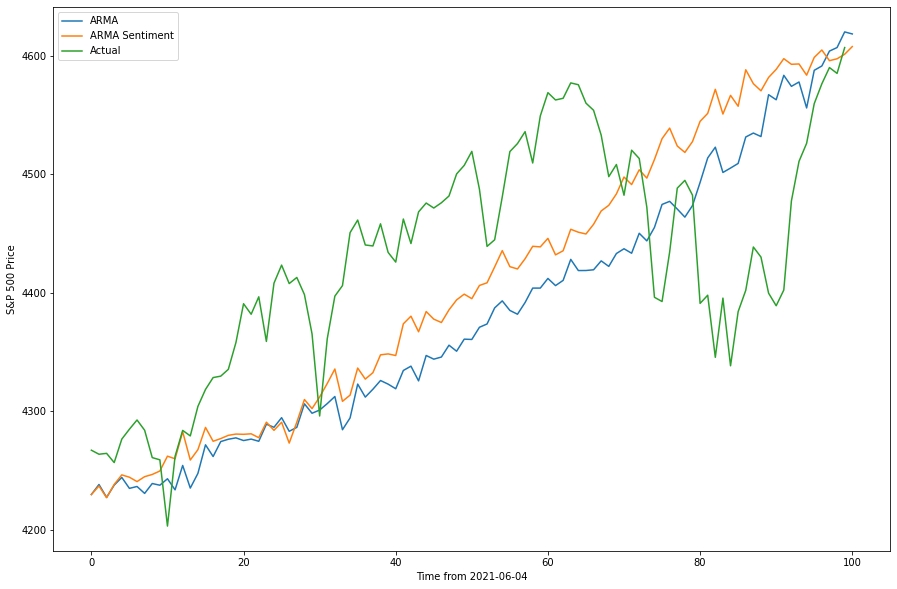

In [84]:
plt.plot(arma_price, label='ARMA')
plt.plot(sentiment_price, label='ARMA Sentiment')
plt.plot(actual_price, label='Actual')
plt.legend()
plt.ylabel("S&P 500 Price")
plt.xlabel("Time from {}".format(prices.index[-training_size].date()))
plt.show()